# Install Modules

# Import libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import control
import math
from filterpy.kalman import ExtendedKalmanFilter

# Filtering
The following snippet generates a random walk and a noisy measurement of the random walk. Our objective is to estimate the random walk while only using the measurement.
For the first experiment, our disturbance and noise has a standard deviation of 1 and 5, respectively.

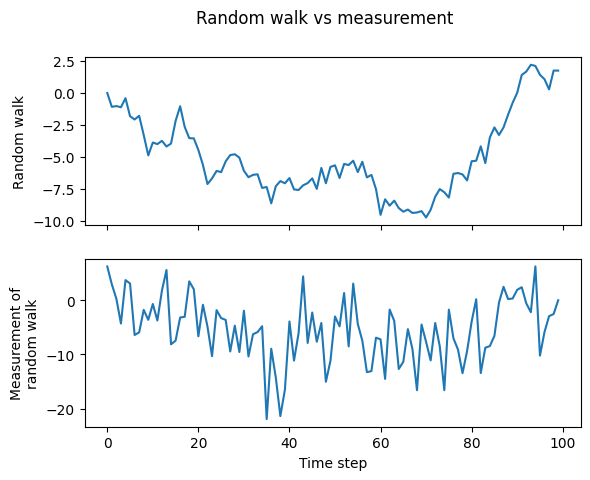

In [8]:
def walk_measurement(disturbance, noise):
    """Generate a random walk and a measurement of that code

    Args:
        disturbance (float): random error on walk
        noise (float): random error on measurement

    Returns:
        rwalk (float[]): random walk data
        measurement (float[]): measurements of random walk
    """

    # Generate a random walk
    # Next point is current point plus gaussian noise
    rwalk=[0]
    for i in range(99):
        rwalk.append(rwalk[-1]+np.random.normal(0,disturbance))

    # Generate measurement of random walk
    # Each measurment has guassian noise
    measurement=[i+np.random.normal(0,noise) for i in rwalk]

    return rwalk, measurement


# generate random walk and measurement
rwalk, measurement=walk_measurement(1, 5)

# make figure
fig, axs = plt.subplots(2, sharex = True)
fig.suptitle('Random walk vs measurement')
axs[0].plot(rwalk)
axs[0].set_ylabel("Random walk")
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("Measurement of\nrandom walk")
axs[1].plot(measurement)


We now try to estimate the random walk using the filter function. It takes our current estimate and measurement to return the current estimate.
Tasks:
- Vary the constant w and observe the effect it has on the filtered sequence (how similar it is to the random walk)
- Compute the sqaured error between the filtered sequence and the random walk, the squared error between the measurement and the random walk, and print the ratio between them.
- Try to tune the constant to minimize the error ratio

In [19]:
def filter(estimate, cur_measurement, w):
    """Takes current estimate and current measurement to produce a new estimate

    Args:
        estimate (float): current estimate
        cur_measurement (float): current measurement

    Returns:
        float: new estimate
    """
    return estimate+w*(cur_measurement-estimate)

def error_ratio_for_given_w(rwalk, measurement, w):
    """Make an estimate of the random walk based on the measurements
    Determine the ratio between the error on our estimate and the error
    on the measurement relative to the random walk

    Args:
        rwalk (float[]): random walk
        measurement (float[]): measurement of random walk
        w (float): indicator of how accurate our measurement is. w = 1 means 
                   that we trust the measurment completely. w = 0 means that
                   we trust the estimation completely.

    Returns:
        error_ratio (float): ratio between errors in estimate and errors in
                             the measurement relative to the random walk
    """

    # use measurement to make estimations of random walk
    filtered=[measurement[0]]
    for curr_measure in measurement[1:]:
        filtered.append(filter(filtered[-1], curr_measure, w))
    #plt.plot(filtered)

    # convert to numpy array
    filtered = np.array(filtered)
    rwalk = np.array(rwalk)
    measurement = np.array(measurement)

    # calculate errors
    filtered_error = np.sum((filtered - rwalk)**2)
    measurement_error = np.sum((measurement - rwalk)**2)

    # print errors
    error_ratio = filtered_error/measurement_error
    return error_ratio, filtered

Determine the $w$ value that minmises the error ratio

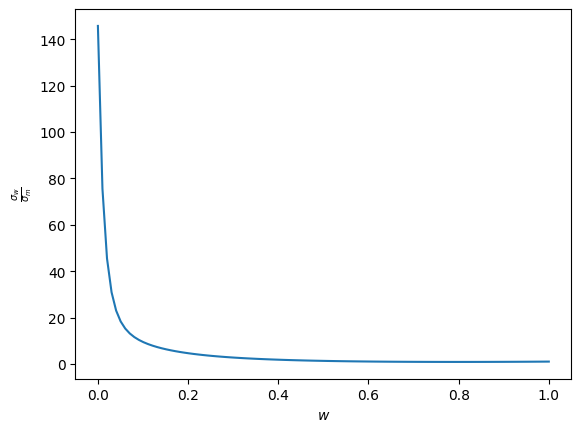

w_min = 0.8562727398292765


In [32]:
def minimum_w(rwalk, measurements):
    """Determine the w value that minimises the error ratio

    Args:
        rwalk (float[]): random walk
        measurements (float[]): measurments of random walk
    """
    w_space = np.linspace(0, 1, 100)
    errors = np.empty(len(w_space))
    for i, w in enumerate(w_space):
        errors[i], _ = error_ratio_for_given_w(rwalk, measurement, w)
    min_w = min(errors)

    return min_w, w_space, errors

# calculate minimum w
min_w, w_space, errors = minimum_w(rwalk, measurement)

# plot w values against the error
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(w_space, errors)
ax.set_xlabel(r"$w$")
ax.set_ylabel(r'$\frac{\sigma_{w}}{\sigma_{m}}$', rotation = 90)
plt.show()

# print result
print(r"w_min = {}".format(min_w))

Now we use the minimum value of $w$ to get predictions for the random walk

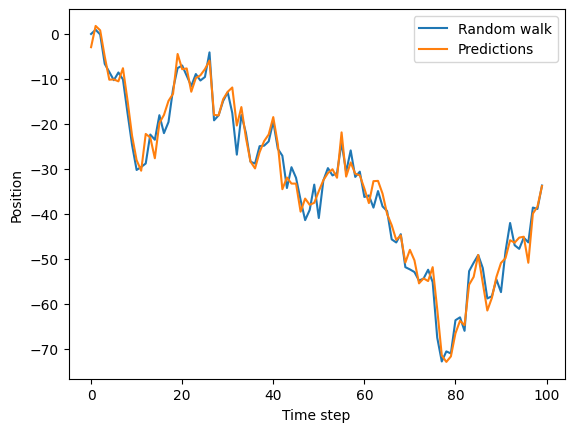

In [30]:
_, rwalk_preds = error_ratio_for_given_w(rwalk, measurement, min_w)

# plot predictions over actual value
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rwalk, label = 'Random walk')
ax.plot(rwalk_preds, label = 'Predictions')
ax.set_xlabel("Time step")
ax.set_ylabel("Position")
ax.legend()

We now change our disturbance and noise to have a variance of 5 and 3, respectively. Repeat the experiment and vary w in filter 2 to minimize the error ratio

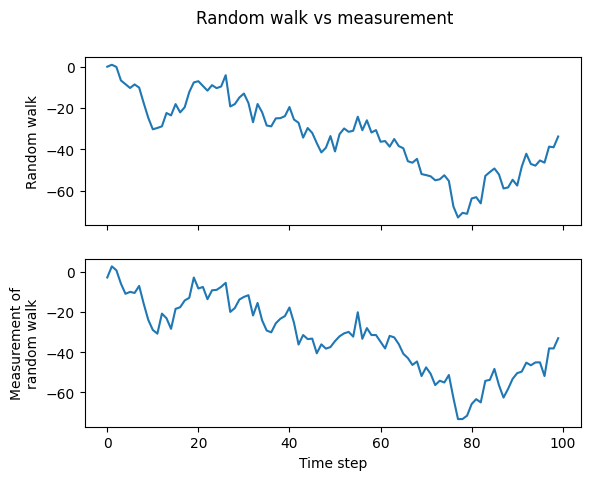

In [11]:
# generate random walk and measurement
rwalk, measurement = walk_measurement(5, 3)

# make figure
fig, axs = plt.subplots(2, sharex = True)
fig.suptitle('Random walk vs measurement')
axs[0].plot(rwalk)
axs[0].set_ylabel("Random walk")
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("Measurement of\nrandom walk")
axs[1].plot(measurement)


In [17]:
error = error_ratio_for_given_w(rwalk, measurement, 0.9)
print(error)

0.8941449204314146


# Alpha Beta filtering
   - The alpha beta filter(also known as g-h filter) assumes that there are two internal state, where the second state is the rate of change of the first state. For instance, an aircraft might need to estimate its position and velocity, but the velocity follows a random walk due to air resistance and we only have access to a noisy sensor that measures the position. The g-h filter estimates both position and velocity based on model prediction and current measurements.  The g parameter determines how much we trust predictions of position relative to measuremnt, while the h parameter determines how much we trust predictions of velocity relative to measurement(derived from change in position). 
   - The difference between the current measurement and estimate of position is called the residual. If the residual is positive, it might mean the previous estimate of position is low, or the previous estimate of velocity is low (since $x_{t+1}=x_t+v$), or some combination of both. The g and h parameters specify how much we should correct the position and velocity estimate, respectively. 

In [13]:
def aircraft(v_unc,x_unc):
    air=[0]
    v=2
    for i in range(99):
        air.append(air[-1]+v)
        v+=np.random.normal(0,v_unc)
    measure=[i+np.random.normal(0,x_unc) for i in air]
    return air, measure
# Parameters: Measured position data, initial velocity, g and h
def g_h_filter(data, v, g, h):
    x_est=data[0]
    filtered=[data[0]]
    for x in data[1:]:
        x_pred=x_est+v
        residual=x-x_pred
        v=v+h*(residual)
        x_est=x_pred+g*residual
        filtered.append(x_est)
    return filtered

# Task:
- Tune the parameters g and h so that the ratio between the error of filtered estimation and the error of measurement is minimized
- Change the variance in the uncertainties for velocity and measurement and repeat the experiment. How should g and h change to accomodate the changes in uncertainty?

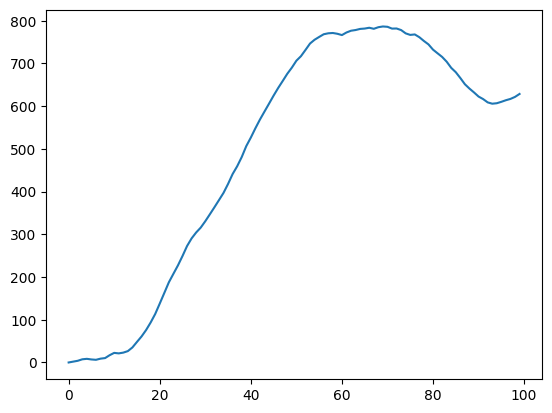

In [14]:
air,measure=aircraft(3,5)
# Tune g and h in ... below
#filtered=g_h_filter(measure,2,g,h)
plt.plot(air)

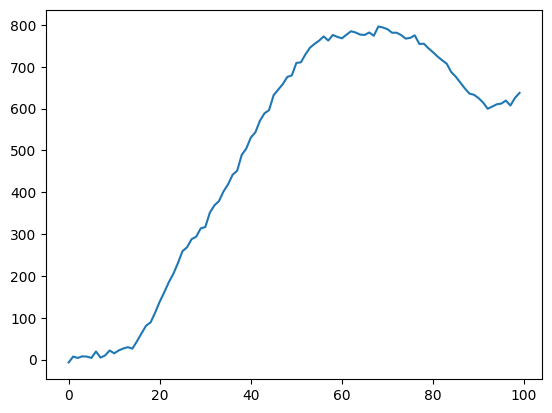

In [15]:
plt.plot(measure)

In [16]:
plt.plot(filtered)
print("error ratio:",sum([(filtered[i]-air[i])**2 for i in range(len(air))])/sum([(measure[i]-air[i])**2 for i in range(len(air))]))

NameError: name 'filtered' is not defined

## Inverted Pendulum
Our inverted pendulum has four variables in its state: The position, velocity, angle and angular velocity. We use the extended kalman filter to estimate the full state and feed it to our controller (the linear quadaratic regulator)

In [ ]:
WINDOWDIMS = (1200, 600)
CARTDIMS = (50, 10)
PENDULUMDIMS = (6, 200)
GRAVITY = 0.13
REFRESHFREQ = 100
A_CART = 0.15

class InvertedPendulum(object):
    def __init__(self, windowdims, cartdims, penddims, gravity, a_cart):
        self.WINDOWWIDTH = windowdims[0]
        self.WINDOWHEIGHT = windowdims[1]

        self.CARTWIDTH = cartdims[0]
        self.CARTHEIGHT = cartdims[1]
        self.PENDULUMWIDTH = penddims[0]
        self.PENDULUMLENGTH = penddims[1]

        self.GRAVITY = gravity
        self.A_CART = a_cart
        self.Y_CART = 3 * self.WINDOWHEIGHT / 4
        self.reset_state()

    def reset_state(self):
        """initializes pendulum in upright state with small perturbation"""
        self.is_dead = False
        self.time = 0
        self.x_cart = self.WINDOWWIDTH / 2
        self.v_cart = 0
        # angle of pendulum (theta = 0 upright, omega positive into the screen)
        self.theta = np.random.uniform(-0.01,0.01)
        self.omega = 0

    def get_state(self):    
        return np.array([self.x_cart+np.random.normal(0,0.01),
                self.v_cart+np.random.normal(0,0.01), self.theta+np.random.normal(0,0.01), self.omega+np.random.normal(0,0.01),1])
    def get_real_state(self):
        return np.array([self.x_cart,
                self.v_cart, self.theta, self.omega,1])
    def set_state(self, state):
        is_dead, t, x, v, theta, omega = state
        self.is_dead = is_dead
        self.time = t
        self.x_cart = x
        self.v_cart = v
        self.theta = theta
        self.omega = omega

    def update_state_(self, action):
        """all the physics is here"""
        if self.is_dead:
            raise RuntimeError("tried to call update_state while state was dead")
        self.time += 1
        self.x_cart += self.v_cart
        # cart stops when it hits the wall
        if self.x_cart <= self.CARTWIDTH / 2 or self.x_cart >= self.WINDOWWIDTH - self.CARTWIDTH / 2:
            self.x_cart = self.WINDOWWIDTH / 2
            #self.v_cart = 0
        # term from angular velocity + term from motion of cart
        self.theta += self.omega + self.v_cart * np.cos(self.theta) / float(self.PENDULUMLENGTH)
        self.omega += self.GRAVITY * np.sin(self.theta) / float(self.PENDULUMLENGTH)
        self.v_cart+=action
        if abs(self.theta) >= np.pi / 2:
            self.is_dead = True
        return self.time, self.x_cart, self.v_cart, self.theta, self.omega
    def update_state(self, action):
        """all the physics is here"""
        if self.is_dead:
            raise RuntimeError("tried to call update_state while state was dead")
        self.time += 1
        self.x_cart += self.v_cart+np.random.normal(0,0.0001)
        # cart stops when it hits the wall
        if self.x_cart <= self.CARTWIDTH / 2 or self.x_cart >= self.WINDOWWIDTH - self.CARTWIDTH / 2:
            self.x_cart = self.WINDOWWIDTH / 2
            #self.v_cart = 0
        # term from angular velocity + term from motion of cart
        self.theta += self.omega + self.v_cart * np.cos(self.theta) / float(self.PENDULUMLENGTH)
        self.omega += self.GRAVITY * np.sin(self.theta) / float(self.PENDULUMLENGTH)
        self.v_cart+=action+np.random.normal(0,0.0001)
        if abs(self.theta) >= np.pi / 2:
            self.is_dead = True
        return self.time, self.x_cart, self.v_cart, self.theta, self.omega


class InvertedPendulumGame(object):
    def __init__(self, windowdims, cartdims, penddims,
                 gravity, a_cart, refreshfreq, pendulum = None):
        if pendulum is None:
            self.pendulum = InvertedPendulum(windowdims, cartdims, penddims, gravity, a_cart)
        else:
            self.pendulum = pendulum
        
        self.WINDOWWIDTH = windowdims[0]
        self.WINDOWHEIGHT = windowdims[1]

        self.CARTWIDTH = cartdims[0]
        self.CARTHEIGHT = cartdims[1]
        self.PENDULUMWIDTH = penddims[0]
        self.PENDULUMLENGTH = penddims[1]

        self.Y_CART = self.pendulum.Y_CART
        # self.time gives time in frames
        self.time = 0
        self.high_score = 0
        
        # array specifying corners of pendulum to be drawn
        self.static_pendulum_array = np.array(
            [[-self.PENDULUMWIDTH / 2, 0],
             [self.PENDULUMWIDTH / 2, 0],
             [self.PENDULUMWIDTH / 2, -self.PENDULUMLENGTH],
             [-self.PENDULUMWIDTH / 2, -self.PENDULUMLENGTH]]).T
        self.BLACK = (0,0,0)
        self.WHITE = (255,255,255)

    @staticmethod
    def rotation_matrix(theta):
        return np.array([[np.cos(theta), np.sin(theta)],
                         [-1 * np.sin(theta), np.cos(theta)]])

    def time_seconds(self):
        return self.time / float(self.REFRESHFREQ)


    def game_round(self,controller):
        np.random.seed(0)
        self.pendulum.reset_state()
        while not self.pendulum.is_dead:
            t, x, _, theta, _ = self.pendulum.update_state(controller(self.pendulum.get_state(),self.pendulum.get_real_state()))
            self.time = t

    def game(self,controller):
        self.game_round(controller)



Task:
- Set our measurement uncertainty matrix (ekf.R) to 0.1 times the identity matrix (use np.eye(5)). This means that the measurement noise variance for each of our variable is 0.1
- Set our model disturbance uncertainty matrix (ekf.Q) to 0.01 times the identity matrix (use np.eye(5)). This means that the model disturbance variance for each of our variable is 0.01
- The true state of the system is x_true, our measurement is x and our estimate is ekf.x. Append the mean squared error of the estimate ($(ekf.x-x_{true})^2$) to the array "filtered"  and the mean squared error of the measurement ($(x-x_{true})^2$) to the array "nonfiltered" 

In [ ]:

#x,x dot,theta, theta dot
WINDOWDIMS = (1200, 600)
CARTDIMS = (50, 10)
PENDULUMDIMS = (6, 200)
GRAVITY = 0.13
REFRESHFREQ = 100
A_CART = 0.15
inv = InvertedPendulumGame(WINDOWDIMS, CARTDIMS, PENDULUMDIMS, GRAVITY, A_CART, REFRESHFREQ)
A_=None
B_=None
u=None
filtered=[]
nonfiltered=[]

def Hj(x):
    return np.eye(5)
def H(x):
    return x

ekf=ExtendedKalmanFilter(dim_x=5,dim_z=5,dim_u=1)
# Set the covariance matrix for noises and disturbances
#ekf.R=...
#ekf.Q=...
def kalman(x,u):
    ekf.predict_update(x,Hj,H,u=u)
def controller(x,x_true):
    global ekf,A_,B_,u
    if u is None:
        ekf.x=x
    else:
        kalman(x,u=np.array([u]))
    #nonfiltered.append(...)
    #filtered.append(...)
    nonfiltered.append(np.mean((x-x_true)**2))
    filtered.append(np.mean((ekf.x-x_true)**2))
    A=np.array([0,1,0,0,0,0,0,0,0,0,0,np.cos(x[2])/float(inv.pendulum.PENDULUMLENGTH),0,1,0,0,0,0,0,inv.pendulum.GRAVITY*np.sin(x[2])/float(inv.pendulum.PENDULUMLENGTH),0,0,0,0,0]).reshape(5,5)
    B=np.array([0,1,0,0,0]).reshape(5,1)
    C=np.eye(5)
    D=np.zeros((5,1))
    system=control.StateSpace(A,B,C,D,dt=1)
    Q=np.array([0,0,0,0,0,0,0,0,0,0,0,0,1000,0,0,0,0,0,10,0,0,0,    0,0,0]).reshape(5,5)
    R=np.array([0])
    K,S,E=control.lqr(system,Q,R)
    u,ekf.F,ekf.B=-K[0].dot(ekf.x),A+np.eye(5),B
    return u
    return 10
inv.game(controller)

Run the following snippet to plot the errors

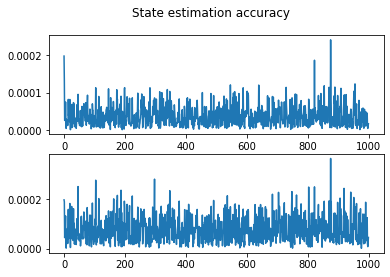

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('State estimation accuracy')
axs[0].plot(filtered[:1000])
axs[1].plot(nonfiltered[:1000])